In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import scipy.special
import scipy.optimize

c = 299792458

In [2]:
occultations = [{'name' : '2019-02-04T08:19:11_436.4MHz', 'sel' : slice('2019-02-04T10:05', '2019-02-04T10:08'),
                    'fit_sel' : slice('2019-02-04T10:06:30', '2019-02-04T10:07:15'), 'direction' : -1,
                    'smooth' : '1s'},
                {'name' : '2019-02-13T20:31:27_436.4MHz', 'sel' : slice('2019-02-13T21:30:50', '2019-02-13T21:31:30'),
                    'fit_sel' : slice('2019-02-13T21:31:07', '2019-02-13T21:31:13'), 'direction' : -1,
                    'vel_hint_correction' : 1.4},
                {'name' : '2019-02-15T13:29:02_436.4MHz', 'sel' : slice('2019-02-15T14:23:20', '2019-02-15T14:23:50'),
                    'fit_sel' : slice('2019-02-15T14:23:33', '2019-02-15T14:23:38'), 'direction' : -1,
                    'vel_hint_correction' : 1.7},
                {'name' : '2019-02-15T13:29:02_436.4MHz', 'sel' : slice('2019-02-15T14:51:30', '2019-02-15T14:52:05'),
                    'fit_sel' : slice('2019-02-15T14:51:45', '2019-02-15T14:51:49'), 'direction' : 1},
               ]

In [3]:
def plot_occultation(occ):
    power = xr.open_dataset(f"output/{occ['name']}_power.nc")
    plt.figure(figsize=(14,8),facecolor='w')
    sel = occ['sel']
    power['power_direct'].sel(time = sel).plot()
    plt.title(f'DSLWP-B lunar occultation {sel.start} - {sel.stop}')
    plt.xlabel('UTC time')
    plt.ylabel('Power (linear scale)')

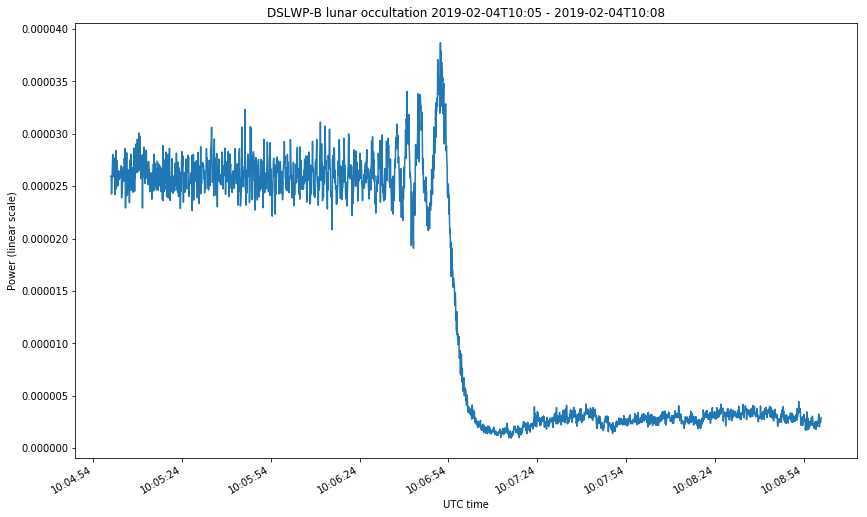

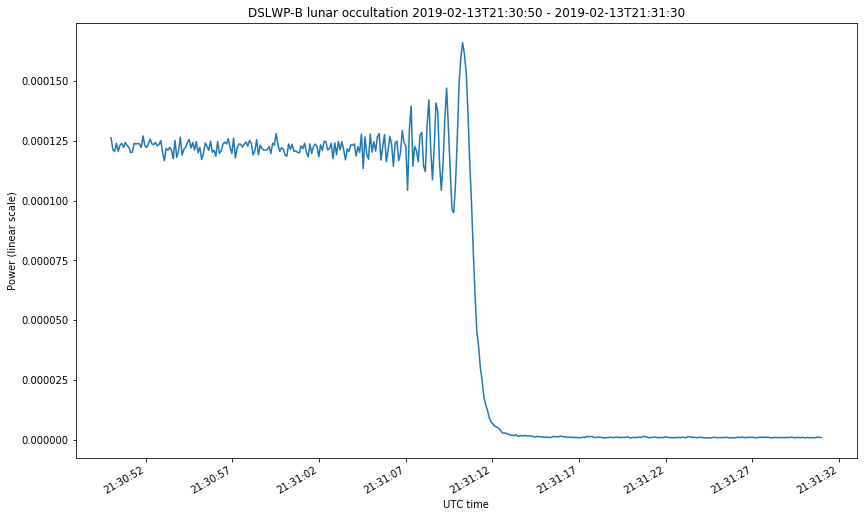

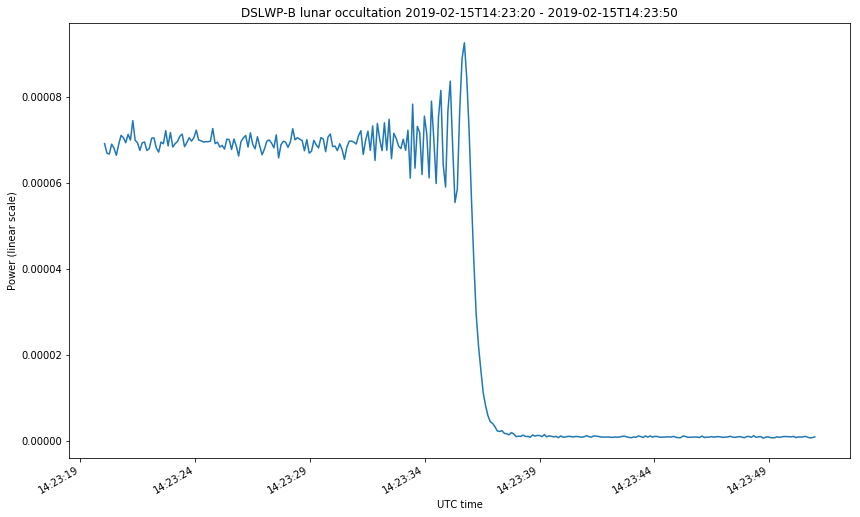

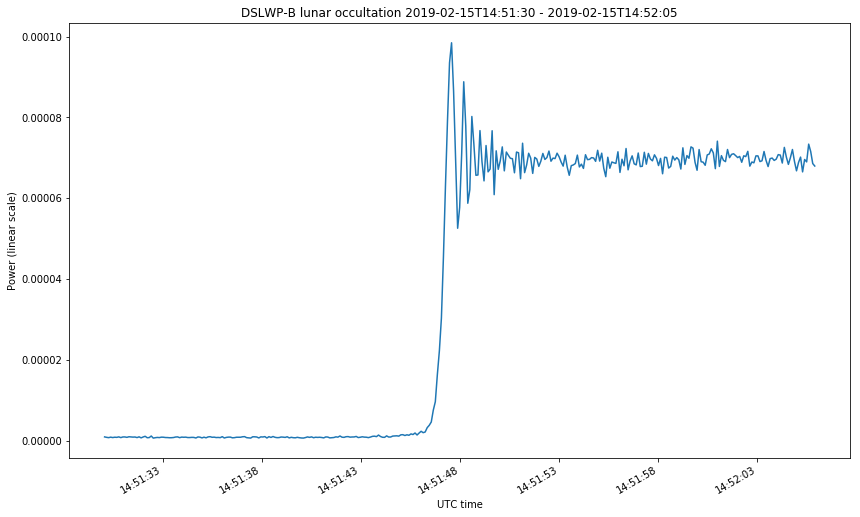

In [4]:
for occultation in occultations:
    plot_occultation(occultation)

In [5]:
def diffraction(t, t0, A, v):
    x = scipy.special.fresnel(v*(t-t0))
    x = A*0.5*((x[0] + 0.5)**2 + (x[1] + 0.5)**2)
    return x

In [6]:
def fit_occultation(occ):
    power = xr.open_dataset(f"output/{occ['name']}_power.nc")
    data = power['power_direct'].sel(time = occ['fit_sel'])
    try:
        data_res = data.resample(time = occ['smooth']).mean()
        data_original = data
        data = data_res
    except KeyError:
        data_original = data
    
    t = data.coords['time']
    s = (t - t[t.size//2]).values.astype('float') * 1e-9
    t_original = data_original.coords['time']
    s_original = (t_original - t_original[t_original.size//2]).values.astype('float') * 1e-9
    
    cut = np.mean(data)
    offset = int(np.argmin(np.abs(data-cut)).values)
    first_max = offset
    d = occ['direction']
    while data[first_max] <= data[first_max+d]:
        first_max += d
    first_min = first_max
    while data[first_min] >= data[first_min+d]:
        first_min += d
    space_hint = s[first_min]-s[first_max]
    
    p0 = (s[offset], data[first_min:].mean().values, 0.5/space_hint * occ.get('vel_hint_correction', 1))
    try:
        popt, pcov = scipy.optimize.curve_fit(diffraction, s_original, data_original, p0 = p0)
        optimization_succeeded = True
        occ['fit_t0'] = t[t.size//2].values + popt[0] * 1e9 * np.timedelta64(1, 'ns')
        occ['fit_v'] = popt[2]
    except RuntimeError:
        optimization_succeeded = False
    
    plt.figure(figsize = (14,8), facecolor='w')
    (1/popt[1]*data_original).plot()
    if optimization_succeeded:
        plt.plot(t_original, 1/popt[1]*diffraction(s_original, *popt))
    
    plt.title(f"Diffraction fit {occ['sel'].start} - {occ['sel'].stop}")
    plt.xlabel('UTC time')
    plt.ylabel('Relative power (linear scale)')
    plt.legend(['Measurements', 'Model fit'])

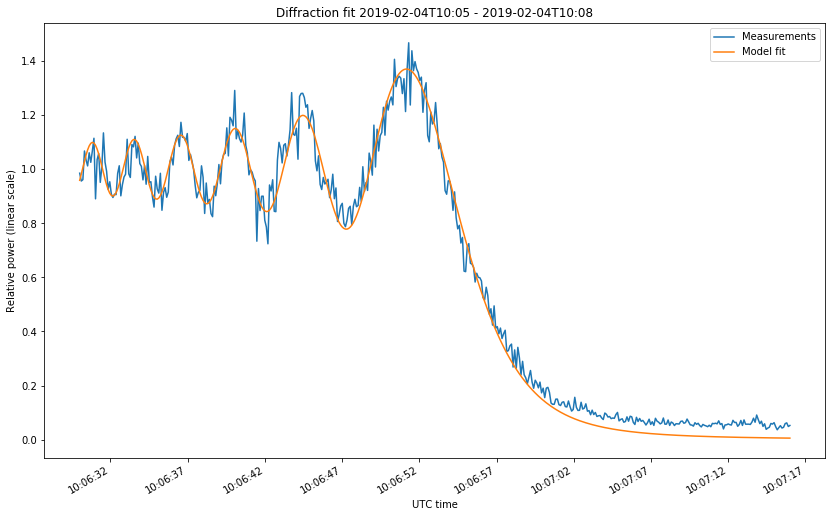

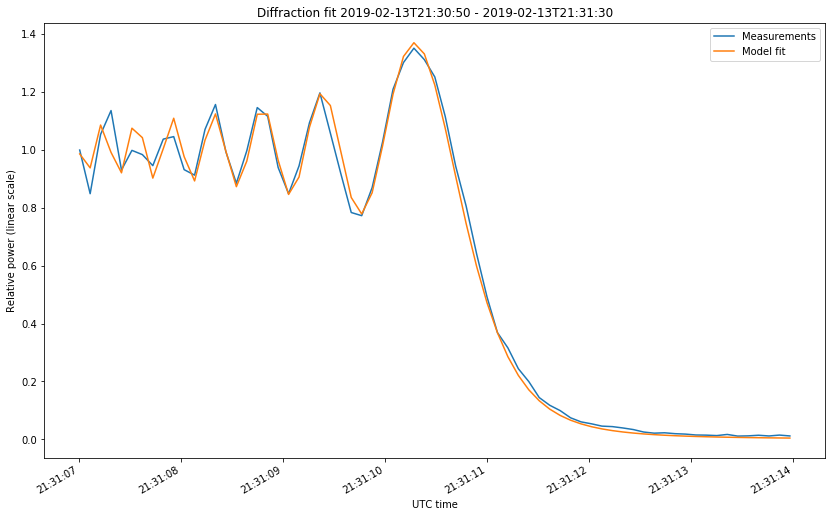

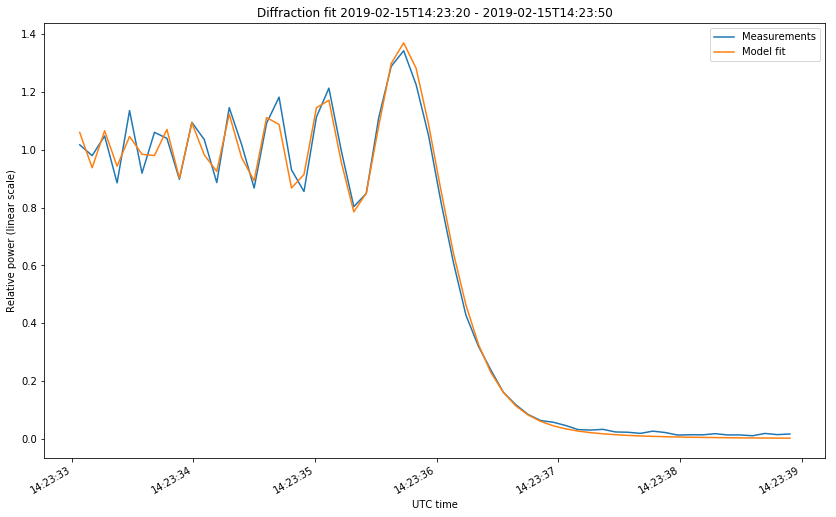

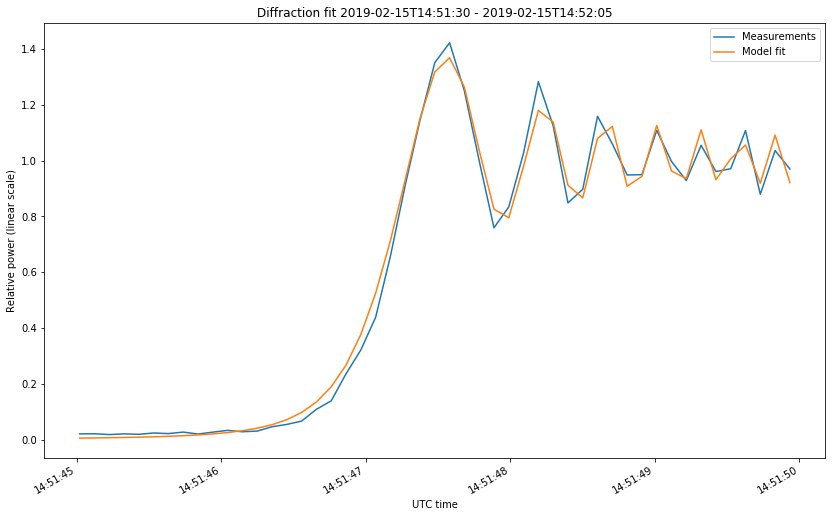

In [7]:
for occ in occultations:
    fit_occultation(occ)

In [8]:
def compute_occultation_from_gmat(occ):
    gmat = xr.open_dataset(f"output/{occ['name']}_gmat.nc")
    a = gmat['gmat'].sel(object = 'dslwpb_lunafixed_x')
    b = gmat['gmat'].sel(object = 'gs_lunafixed_x')
    d = b - a
    u = d/np.sqrt((d**2).sum('xyz'))
    A = np.abs((a*u).sum('xyz'))
    B = np.abs((b*u).sum('xyz'))
    H = np.sqrt((a**2).sum('xyz') - A**2)
    R = 1737.1 # lunar radius
    x = H - R
    delta = np.sqrt(A**2 + x**2) + np.sqrt(B**2 + x**2) - A - B
    lbd = c / 436.4e6
    nu = 2*np.sqrt(1e3*delta/lbd)*np.sign(x)
    dnu = nu.differentiate('time', datetime_unit='s')
    search_t0 = slice(occ['fit_t0'] + np.timedelta64(-300,'s'), occ['fit_t0'] + np.timedelta64(300,'s'))
    occ['gmat_t0'] = gmat.coords['time'].sel(time = search_t0)[np.abs(nu.sel(time = search_t0)).argmin()].values
    occ['gmat_v'] = float(dnu.interp(time = occ['fit_t0']).values)

In [9]:
for occultation in occultations:
    compute_occultation_from_gmat(occultation)

In [10]:
[1-o['fit_v']/o['gmat_v'] for o in occultations]

[0.012628611461853678,
 -0.14849525967852584,
 -0.03838583537440288,
 0.021923209485447237]

In [11]:
[(o['fit_t0']-o['gmat_t0']).astype('float')*1e-9 for o in occultations]

[-116.05367306500001, 13.311127206, 31.371431057000002, 41.360679158]